In [37]:
import os
import sys

curr_path = !pwd
curr_path = curr_path[0]
curr_path

'/Users/jonathanperalgort/Documents/DL-CMPT420/final_project/src/tests/notebooks'

In [38]:

utils_path = os.path.join(os.path.dirname(curr_path), '..', 'utils')

sys.path.append(utils_path)

In [39]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from DataLoader import CelebADataset
from PruningHelper import PruningHelper as ph
from torch.nn.utils.prune import global_unstructured, L1Unstructured
from torch.utils.data import random_split, DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Hyperparameters

Since we're going to be experimenting on a small dataset, we can afford to have a relatively larger number of k-folds (5-9). In which case, we're going to choose 9 so as to reduce bias as much as possible.

In [41]:
sample_seed = 42
sample_size = 1000
k_folds = 9
epochs = 100
classes = 'is_blonde'

batch_size = 64


In [16]:
dataset_path = f"../../../dataset/Img/img_align_celeba"
att_path = f"../../../dataset/Anno/list_attr_celeba.txt"

dataset = CelebADataset(dataset_path, att_path)

#### Dataset split:

In [17]:
test_size = int(0.1 * sample_size)
train_size = sample_size - test_size

# Generator
generator = torch.Generator().manual_seed(sample_seed)

# Data Sampling
sample_indices = torch.randperm(len(dataset))[:sample_size]
ds_sample = Subset(dataset, sample_indices)
ds_train, ds_test = random_split(ds_sample, [train_size, test_size], generator=generator)

In [18]:
total_size = len(dataset)
total_size #182,340 = total * .9

202599

In [19]:
print(f"Train size: {len(ds_train)}, Test size: {len(ds_test)}")

Train size: 900, Test size: 100


In [20]:
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=False)

### Pruning settings


In [21]:
prune_start_step = 17
prune_iter_step = 25

In [22]:
total_steps = ph.get_total_steps(len(ds_train), batch_size, k_folds, epochs)
pruning_schedule = ph.get_pruning_schedule(total_steps, pruning_start=prune_start_step, pruning_interval=prune_iter_step)
pruning_rate = ph.get_pruning_rate(pruning_schedule, 0.9)
pruning_schedule, pruning_rate

([17,
  42,
  67,
  92,
  117,
  142,
  167,
  192,
  217,
  242,
  267,
  292,
  317,
  342,
  367,
  392,
  417,
  442,
  467,
  492,
  517,
  542,
  567,
  592,
  617,
  642,
  667,
  692,
  717,
  742,
  767,
  792,
  817,
  842,
  867,
  892,
  917,
  942,
  967,
  992,
  1017,
  1042,
  1067,
  1092,
  1117,
  1142,
  1167,
  1192,
  1217,
  1242,
  1267,
  1292,
  1317,
  1342,
  1367,
  1392,
  1417,
  1442,
  1467,
  1492,
  1517,
  1542,
  1567,
  1592,
  1617,
  1642,
  1667,
  1692,
  1717,
  1742,
  1767,
  1792,
  1817,
  1842,
  1867,
  1892,
  1917,
  1942,
  1967,
  1992,
  2017,
  2042,
  2067,
  2092,
  2117,
  2142,
  2167,
  2192,
  2217,
  2242,
  2267,
  2292,
  2317,
  2342,
  2367,
  2392,
  2417,
  2442,
  2467,
  2492,
  2517,
  2542,
  2567,
  2592,
  2617,
  2642,
  2667,
  2692,
  2717,
  2742,
  2767,
  2792,
  2817,
  2842,
  2867,
  2892,
  2917,
  2942,
  2967,
  2992,
  3017,
  3042,
  3067,
  3092,
  3117,
  3142,
  3167,
  3192,
  3217,
  3242,
  32

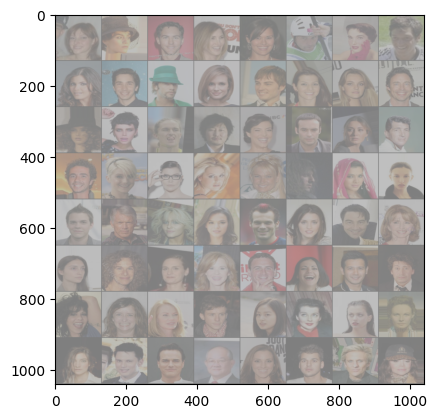

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 4 + 0.5
    npimg  =img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# get random training img
dataiter = iter(train_loader)
images, labels, _ = next(dataiter)

# show img
imshow(torchvision.utils.make_grid(images))

In [24]:
def check_sparsity(model):
    total_active_w = 0
    total_w = 0
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            total_active_w += torch.sum(module.weight == 0).item()
            total_w += module.weight.numel()

    return 100 * (total_active_w / total_w)

In [31]:
def trainer(model, optimizer, pruning=False):
    criterion = nn.BCEWithLogitsLoss()

    kf = KFold(n_splits=k_folds, shuffle=True)

    total_precision = []
    total_recall = []
    total_f1_score = []

    # Training
    step = 0
    num_of_prunes = 0
    for fold, (train_k, val_k) in enumerate(kf.split(ds_train)):

        train_loader_k = DataLoader(dataset=ds_train, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(train_k))

        val_loader_k = DataLoader(
            dataset=ds_train,
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(val_k)
        )

        model.train()
        for epoch in range(epochs):
            for imgs, lbls, _ in train_loader_k:
                imgs, lbls = imgs.to(device), lbls.to(device)

                outputs = model(imgs).squeeze(1)

                loss = criterion(outputs, lbls)

                optimizer.zero_grad()
                loss.backward()

                # Add step
                step+=1

                # Pruning
                if pruning and (step in pruning_schedule):
                    num_of_prunes += 1
                    global_unstructured(
                        [(m, 'weight') for m in model.modules() if isinstance(m, (nn.Conv2d, nn.Linear))],
                        pruning_method=L1Unstructured,
                        amount=pruning_rate,
                    )
                    print(f"[Step {step}]Num of prunes -> {num_of_prunes}\nTotal sparsity: {check_sparsity(model)}")


                optimizer.step()
            print(f"Fold: {fold+1}, Epoch: [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

        # Evaluation of model
        model.eval()
        total=0
        correct=0
        y_pred = []
        y_true = []

        with torch.no_grad():
            for imgs, lbls, _ in val_loader_k:
                imgs, lbls = imgs.to(device), lbls.to(device)
                outputs = model(imgs)

                _, predicted = torch.max(outputs, 1)
                y_true.extend(lbls.cpu().numpy()) #storing true values
                y_pred.extend(predicted.cpu().numpy()) #storing predictions
                total += lbls.size(0)
                correct += (predicted == lbls).sum().item()

        precision = precision_score(y_true, y_pred, average='macro', zero_division=np.nan)
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        total_precision.append(precision)
        total_recall.append(recall)
        total_f1_score.append(f1)

        print(f"Fold: [{fold + 1}/{k_folds}], Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")
    
    print(f"Avg. precision: {np.mean(total_precision):.2f}")
    print(f"Avg. Recall: {np.mean(total_recall):.2f}")
    print(f"Avg. F1-score: {np.mean(total_f1_score):.2f}")

    print("Training Completed")
    print(f"Number of steps {step}")

    return model

In [32]:
def test_model(model, test_loader):
    print("Test Evaluation")

    y_pred_test = []
    y_true_test = []

    with torch.no_grad():
        for imgs, lbls, _ in test_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)

            outputs = model(imgs)
            _, predicted = torch.max(outputs,1)

            y_true_test.extend(lbls.cpu().numpy())
            y_pred_test.extend(predicted.cpu().numpy())

    precision_test = precision_score(y_true_test, y_pred_test, average='macro', zero_division=np.nan)
    recall_test = recall_score(y_true_test, y_pred_test, average='macro')
    f1_score_test = f1_score(y_true_test, y_pred_test, average='macro')

    print(f"Test precision: {precision_test:.2f}")
    print(f"Test recall: {recall_test:.2f}")
    print(f"Test f1-score: {f1_score_test:.2f}")

    print("Finished test evaluation!")

### Initializing model

In [33]:
from ResNet import ResNet, BasicBlock

def ResNet18(num_classes=1):
    resnet = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
    return resnet

model = ResNet18().to(device)

In [34]:
resnet_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total # of params: {resnet_total_params}")

Total # of params: 11177025


### Choosing optimizer

In [35]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [36]:
trained_model = trainer(model=model, optimizer=optimizer, pruning=False)

Fold: 1, Epoch: [1/100], Loss: 0.4846
Fold: 1, Epoch: [2/100], Loss: 0.3200
Fold: 1, Epoch: [3/100], Loss: 0.1504
Fold: 1, Epoch: [4/100], Loss: 0.1829


KeyboardInterrupt: 

In [ ]:
check_sparsity(trained_model) # Percentage of weights removed

90.00003044569634

In [35]:
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

In [36]:
test_model(model=model,test_loader=test_loader)

Test Evaluation
Test precision: 0.86
Test recall: 0.50
Test f1-score: 0.46
Finished test evaluation!


### Determining CIEs

In [ ]:
def get_cie_count(model_1, model_2, test_loader):
        print("Determining CIEs:")

        model_1.eval()
        model_2.eval()
        cie_list = []

        with torch.no_grad():
            for imgs, lbls, sample_name in test_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)

                outputs_1 = model_1(imgs).squeeze(1)
                predicted_1 = (torch.sigmoid(outputs_1) > 0.5).float()

                outputs_2 = model_2(imgs).squeeze(1)
                predicted_2 = (torch.sigmoid(outputs_2) > 0.5).float()

                disagree_mask = (predicted_1 != predicted_2)

                for i in range(len(sample_name)):
                     if disagree_mask[i]:
                          cie_list.append(sample_name[i])

        print(f"Number of CIEs: {len(cie_list)}")

        return cie_list